In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
%matplotlib inline
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
batch_size = 10
num_epochs = 40

In [3]:
class SignalsDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform=None):
        self.signals_frame = pd.read_csv(csv_file)
        self.signals_frame = self.signals_frame.iloc[:,:-1] # removing last column - not needed
        
    def __len__(self):
        return len(self.signals_frame)
    
    def __getitem__(self, idx):
        
        d = self.signals_frame.iloc[idx,:].values
        d = torch.from_numpy(d).float()
        d = d.view(1, 187) # gives one ecg signal
        sample = {'data': d.float(), 'target':d.float()}
        
        return sample 

In [5]:
# train_dataset = SignalsDataset(csv_file="training.csv", 
#                                   root_dir="Heart")
train_dataset = SignalsDataset(csv_file="mitbih_train.csv",root_dir="~/")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)


In [6]:
train_dataset.__getitem__(0)

{'data': tensor([[0.9601, 0.8632, 0.4615, 0.1966, 0.0940, 0.1254, 0.0997, 0.0883, 0.0741,
          0.0826, 0.0741, 0.0627, 0.0655, 0.0655, 0.0627, 0.0769, 0.0712, 0.0826,
          0.0912, 0.0969, 0.0826, 0.0826, 0.0912, 0.1054, 0.1225, 0.1481, 0.1823,
          0.1937, 0.2137, 0.2080, 0.2222, 0.2536, 0.2707, 0.2877, 0.2849, 0.2934,
          0.2564, 0.2479, 0.1880, 0.1453, 0.1083, 0.0826, 0.0798, 0.0741, 0.0142,
          0.0114, 0.0627, 0.0513, 0.0570, 0.0484, 0.0285, 0.0313, 0.0769, 0.0256,
          0.0285, 0.0370, 0.0940, 0.0855, 0.0399, 0.0598, 0.0741, 0.0798, 0.0912,
          0.0997, 0.1083, 0.0883, 0.0912, 0.0655, 0.0855, 0.0883, 0.0769, 0.0826,
          0.0969, 0.0997, 0.1339, 0.1026, 0.0399, 0.0655, 0.0741, 0.0826, 0.0855,
          0.0570, 0.0456, 0.1026, 0.0399, 0.0114, 0.0171, 0.0313, 0.0057, 0.0085,
          0.0313, 0.0513, 0.0570, 0.0883, 0.0655, 0.0114, 0.0570, 0.0399, 0.0399,
          0.0256, 0.0028, 0.0199, 0.0256, 0.0114, 0.0285, 0.0199, 0.0228, 0.0342,
        

In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.enc_layer1 = nn.Conv1d(1, 4, kernel_size=4, stride=1)
        self.enc_layer2 = nn.Conv1d(4, 16, kernel_size=4, stride=1)
        self.enc_layer3 = nn.Conv1d(16, 32, kernel_size=4, stride=1)
        
        self.dec_layer4 = nn.ConvTranspose1d(in_channels=32,out_channels=16,kernel_size=4)
        self.dec_layer5 = nn.ConvTranspose1d(in_channels=16,out_channels=4,kernel_size=4)
        self.dec_layer6 = nn.ConvTranspose1d(in_channels=4,out_channels=1,kernel_size=4)
        

        
    def forward(self, x):
        #x = x.float()
        x = self.enc_layer1(x)
        x = self.enc_layer2(x)
        x = self.enc_layer3(x)
        
        x = self.dec_layer4(x)
        x = self.dec_layer5(x)
        x = self.dec_layer6(x)
        
        return x    

In [11]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
losses =[]
for epoch in range(num_epochs):
    model.train()
    for i,sample in enumerate(train_loader):
        data, target = sample['data'], sample['target']
        #print(data.size())
        #data = data.view(10,1,187)
        #print(data)
        #print(data.shape)
        #target = target.view(10,1,187)
        #print(target.shape)
        data = data.to(device)
        target = target.to(device)
        


        # ===================forward=====================
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        # ===================backward====================
        loss.backward()
        optimizer.step()
    # ===================log========================
    losses.append([epoch+1,loss.item()])
    
    print('epoch [{}/{}], loss:{:.8f}'
          .format(epoch + 1, num_epochs, loss.item()))

epoch [1/40], loss:0.00001761
epoch [2/40], loss:0.00000109
epoch [3/40], loss:0.00001466
epoch [4/40], loss:0.00000950
epoch [5/40], loss:0.00000531
epoch [6/40], loss:0.00000150
epoch [7/40], loss:0.00000217
epoch [8/40], loss:0.00000226
epoch [9/40], loss:0.00000066
epoch [10/40], loss:0.00000742
epoch [11/40], loss:0.00000627
epoch [12/40], loss:0.00074548
epoch [13/40], loss:0.00000298
epoch [14/40], loss:0.00000982
epoch [15/40], loss:0.00000070
epoch [16/40], loss:0.00000685
epoch [17/40], loss:0.00000284
epoch [18/40], loss:0.00000154
epoch [19/40], loss:0.00000489
epoch [20/40], loss:0.00000208
epoch [21/40], loss:0.00048163
epoch [22/40], loss:0.00000246
epoch [23/40], loss:0.00000324
epoch [24/40], loss:0.00000328
epoch [25/40], loss:0.00000692
epoch [26/40], loss:0.00000455
epoch [27/40], loss:0.00000320
epoch [28/40], loss:0.00000542
epoch [29/40], loss:0.00000443
epoch [30/40], loss:0.00000144
epoch [31/40], loss:0.00000326
epoch [32/40], loss:0.00000300
epoch [33/40], lo

In [57]:
losses = np.asarray(losses)
np.shape(losses)


(40, 2)

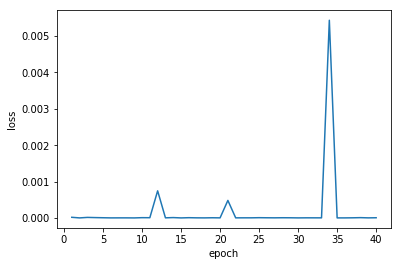

In [60]:
plt.plot(losses[:,0],losses[:,1])
plt.ylabel('loss');
plt.xlabel('epoch');